# **In-Class Assignment: Named Entity Recognition**

## Name: KEY
## *IS 5150*

As with most NLP applications we've discussed so far in this course, there are pretrained versions that are ready to go 'out of the box' and there are tools to develop your own. This is the case for different forms of text annotation, including POS tagging, syntax parsing, and NER.

Though SpaCy doesn't indicate exactly how its NER tagger works, an important step in NER is first identifying the noun phrases in the text, that are then further filtered down to named entities and then classified into their respective types.

Noun phrases are identified by first applying POS tags to text and then parsing the syntax to identify the constituents or dependents in a noun phrase. Therefore we will investigate each "step" in this process, starting with POS tagging, then syntax parsing, followed by NER, all using prebuilt SpaCy models.

In [ ]:
import spacy
spacy.load('en_core_web_sm')
from spacy import displacy

import graphviz
import pydot_ng
!pip install svgling
import svgling

import pandas as pd
import os

import nltk
nltk.download('treebank')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk import Nonterminal
from nltk.corpus import treebank

from collections import Counter
import re

## POS Tagging

**Produce your own sample sentences or set of sentences and use the `SpaCy` POS tagger to reveal its predicted POS as well as the tag type. I pulled in a news headline, which tend to have lots of named entities within them. How does it perform?**

In [ ]:
sentence = "Joe Biden is unhappy with Elon Musk for buying Twitter, a platform that spews lies."

nlp = spacy.load('en_core_web_sm')

In [ ]:
sentence_nlp = nlp(sentence) # tokenize sentence

spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns = ['Word', 'POS Tag', 'Tag type']).T

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
Word,The,Didgeridoo,is,a,wind,instrument,that,produces,a,continuous,...,while,using,a,special,breathing,technique,called,circular,breathing,.
POS Tag,DT,NNP,VBZ,DT,NN,NN,WDT,VBZ,DT,JJ,...,IN,VBG,DT,JJ,NN,NN,VBN,JJ,NN,.
Tag type,DET,PROPN,AUX,DET,NOUN,NOUN,PRON,VERB,DET,ADJ,...,SCONJ,VERB,DET,ADJ,NOUN,NOUN,VERB,ADJ,NOUN,PUNCT


In [ ]:
spacy.explain("SCONJ")

'subordinating conjunction'

**What effect does captilization have on noun classification?**

## Syntax Parsing

We will now implemenet different forms of syntax parsing in order to identify not just nouns,  but noun phrases, which are identified and classified in named entity recognition. 

**What is the difference between constituency and dependency parsing?**

Constituency parsing is "context-free", meaning that its parsing scheme is based on known grammatical rules about what word types can be used to construct a given phrase type and how different POS can be ordered. Constituency parse trees are hierarchical and start with a root at the highest level constituent, clause type, followed by phrase type, and word type, with the actual word token as the nodes of the tree.

Dependency parsing is used to understand structure and semantic dependecnies between tokens in a sentence, using directed graphs to provide links between nodes in the graph, where all nodes are lexical tokens (words) and their labeled edges are the relationships between the "root" word and its dependents. All words except that "root" word have a dependency on other words in the sentence, where the root is usually a verb. All other words are directly or indirectly dependent on the root.

In [ ]:
sentence = "Joe Biden is unhappy with Elon Musk for buying Twitter, a platform that spews lies."
sentence_nlp = nlp(sentence)

dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n---------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_,
                                   w_type=token.dep_,
                                   left=[t.orth_
                                        for t 
                                        in token.lefts],
                                   right=[t.orth_
                                         for t in
                                         token.rights]))

[]<---Joe[compound]--->[]
---------
['Joe']<---Biden[nsubj]--->[]
---------
['Biden']<---is[ROOT]--->['unhappy', '.']
---------
[]<---unhappy[acomp]--->['with', 'for']
---------
[]<---with[prep]--->['Musk']
---------
[]<---Elon[compound]--->[]
---------
['Elon']<---Musk[pobj]--->[]
---------
[]<---for[prep]--->['buying']
---------
[]<---buying[pcomp]--->['Twitter']
---------
[]<---Twitter[dobj]--->[',', 'platform']
---------
[]<---,[punct]--->[]
---------
[]<---a[det]--->[]
---------
['a']<---platform[appos]--->['lies']
---------
[]<---that[nsubj]--->[]
---------
['that']<---spews[nsubj]--->[]
---------
['spews']<---lies[relcl]--->[]
---------
[]<---.[punct]--->[]
---------


In [ ]:
displacy.render(sentence_nlp, jupyter = True,
               options={'distance': 110,
                       'arrow_stroke': 2,
                       'arrow_width': 8})

**What is the root in this case and what does that mean? Who is the subject and what does that mean?**

In [ ]:
training_set = treebank.parsed_sents()

treebank_productions = list(
                        set(production
                           for sent in training_set
                           for production in sent.productions()
                           )
                        )

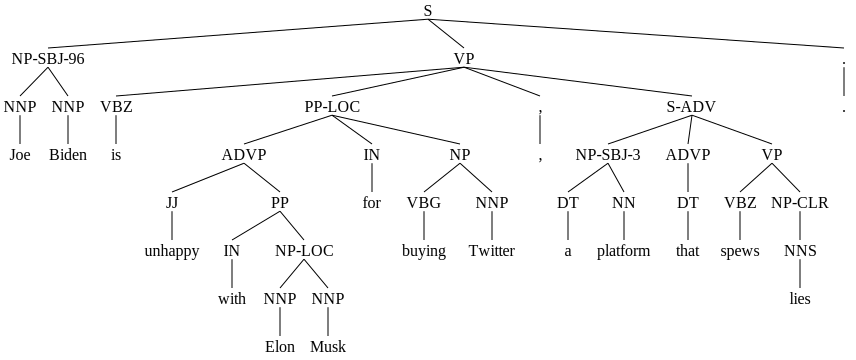

In [ ]:
tokens = nltk.word_tokenize(sentence)
tagged_sent = nltk.pos_tag(nltk.word_tokenize(sentence))

for word, tag in tagged_sent:
    t = nltk.Tree.fromstring("("+ tag +" "+ word +")")
    for production in t.productions():
        treebank_productions.append(production)
        
        
treebank_grammar = nltk.grammar.induce_pcfg(Nonterminal('S'), treebank_productions)

viterbi_parser = nltk.ViterbiParser(treebank_grammar)
result = list(viterbi_parser.parse(tokens))[0]

result

[Penn Treebank Constituency Tags](http://surdeanu.cs.arizona.edu/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html)

**How does the Constituency Parse tree differ from the Depedency parse graph in its representation of the sample sentence?**

## Named Entity Recognition with Spacy

Next let's bring in a larger text to perform NER on. Copy some text from a news article and save it to an object called 'text'.

In [ ]:
text = """The relevance of social media platforms in swaying global politics was first highlighted with the rise of Facebook 
rebranded later to Meta, which was accused of manipulating information based on user demographics. Twitter which was recently 
acquired by Elon Musk, got the short end of the stick as US President Joe Biden accused the website of spewing lies. Biden attended 
a fundraising event in Chicago for upcoming elections, wherein he called out Elon Musk for purchasing Twitter. He stated now what 
are we all worried about? Elon Musk goes out and buys an outfit that sends and spews lies all across the world."""

In [ ]:
text = re.sub(r'\n', '', text)
text

'The relevance of social media platforms in swaying global politics was first highlighted with the rise of Facebook rebranded later to Meta, which was accused of manipulating information based on user demographics. Twitter which was recently acquired by Elon Musk, got the short end of the stick as US President Joe Biden accused the website of spewing lies. Biden attended a fundraising event in Chicago for upcoming elections, wherein he called out Elon Musk for purchasing Twitter. He stated now what are we all worried about? Elon Musk goes out and buys an outfit that sends and spews lies all across the world.'

In [ ]:
nlp = spacy.load('en_core_web_sm')
text_nlp = nlp(text)

ner_tagged = [(word.text, word.ent_type_) for word in text_nlp]
print(ner_tagged)

[('The', ''), ('relevance', ''), ('of', ''), ('social', ''), ('media', ''), ('platforms', ''), ('in', ''), ('swaying', ''), ('global', ''), ('politics', ''), ('was', ''), ('first', 'ORDINAL'), ('highlighted', ''), ('with', ''), ('the', ''), ('rise', ''), ('of', ''), ('Facebook', 'ORG'), ('rebranded', ''), ('later', ''), ('to', ''), ('Meta', 'ORG'), (',', ''), ('which', ''), ('was', ''), ('accused', ''), ('of', ''), ('manipulating', ''), ('information', ''), ('based', ''), ('on', ''), ('user', ''), ('demographics', ''), ('.', ''), ('Twitter', ''), ('which', ''), ('was', ''), ('recently', ''), ('acquired', ''), ('by', ''), ('Elon', 'PRODUCT'), ('Musk', 'PRODUCT'), (',', ''), ('got', ''), ('the', ''), ('short', ''), ('end', ''), ('of', ''), ('the', ''), ('stick', ''), ('as', ''), ('US', 'GPE'), ('President', ''), ('Joe', 'PERSON'), ('Biden', 'PERSON'), ('accused', ''), ('the', ''), ('website', ''), ('of', ''), ('spewing', ''), ('lies', ''), ('.', ''), ('Biden', 'PERSON'), ('attended', '')

In [ ]:
displacy.render(text_nlp, style='ent', jupyter=True)

**Examine what was tagged and determine what if anything was not tagged that you feel should have been. Of what was tagged, do the tags accurately reflect the entity?**

In [ ]:
named_entities = []
temp_entity_name = ''
temp_named_entity = None
for term, tag in ner_tagged:
    if tag:
        temp_entity_name = ' '.join([temp_entity_name, term]).strip()
        temp_named_entity = (temp_entity_name, tag)
    else:
        if temp_named_entity:
            named_entities.append(temp_named_entity)
            temp_entity_name = ''
            temp_named_entity = None

In [ ]:
c = Counter([item[1] for item in named_entities])
c.most_common()

[('PRODUCT', 3), ('ORG', 2), ('GPE', 2), ('PERSON', 2), ('ORDINAL', 1)]

In [ ]:
print(named_entities)

[('first', 'ORDINAL'), ('Facebook', 'ORG'), ('Meta', 'ORG'), ('Elon Musk', 'PRODUCT'), ('US', 'GPE'), ('Joe Biden', 'PERSON'), ('Biden', 'PERSON'), ('Chicago', 'GPE'), ('Elon Musk', 'PRODUCT'), ('Twitter', 'PRODUCT')]


**What information can be gathered about the text by filtering down to only named entities? How could extracting named entities from a text be useful for processes like information retrieval (search queries), question-answering, chatbots, etc.?**